In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns
from sklearn import metrics
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

## Load the dataset

In [3]:
train_features = np.load('../Data/UTDMHAD_data/UTD_train_features.npy')
test_features = np.load('../Data/UTDMHAD_data/UTD_test_features.npy')
train_labels = np.load('../Data/UTDMHAD_data/UTD_train_labels.npy')
test_labels = np.load('../Data/UTDMHAD_data/UTD_test_labels.npy')

In [4]:
train_features.shape,  # 688   6 * 128

((688, 6, 128),)

#### Check the labels

In [5]:
train_labels[:100] # Label

array([ 7,  5, 11,  4, 12, 25, 25, 16,  1,  7, 15, 24,  7, 27, 16, 26, 18,
       10, 26, 24, 17, 21, 11, 14,  3,  5, 14,  9, 14, 12, 22, 15, 17,  5,
       14,  6, 17,  2, 15, 21, 17, 14, 14,  7, 19, 19, 27, 11, 25,  2,  7,
       14, 20, 15, 10, 18, 10, 16, 18, 14, 10, 22, 16, 25,  3, 26,  6, 27,
       13, 27,  5,  3, 23,  5,  2, 22,  3, 20, 26, 26, 16, 13,  8,  5,  6,
        1, 15,  7, 12, 15, 12,  5,  6,  1, 18, 11,  3, 19, 10, 14],
      dtype=int64)

#### Building loader
Images size = 6 * 128

In [6]:
tensor_train_features = torch.Tensor(train_features) # torch.Size([688, 6, 128])
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features) # torch.Size([173, 6, 128])
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)# (torch.Size([688, 1, 6, 128]),)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)

In [7]:
tensor_train_features.shape, tensor_train_labels.shape, train_dataset

(torch.Size([688, 1, 6, 128]),
 torch.Size([688]),
 <torch.utils.data.dataset.TensorDataset at 0x267381527c0>)

In [8]:
# Hyper parameter 
BATCH_SIZE = 32 # 
EPOCHES = 10

#### 创建数据集的可迭代对象 Iratable object with batch

In [9]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [10]:
len(train_loader), len(test_loader)

(22, 6)

In [11]:
images,labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 1, 6, 128]), torch.Size([32]))

In [12]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Recovery the image
    inp = np.clip(inp, 0, 1) # clip the pixel between 0 and 1
    plt.imshow(inp)
    #if titlle is not None:
        #plt.title(title)
   

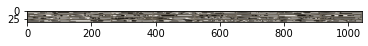

In [13]:
out = torchvision.utils.make_grid(images)
imshow(out)

#### LSTM

In [14]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [15]:
input_dim = 128 # input dimension
hidden_dim = 1000 # hidden layers number
layer_dim = 1 
output_dim = 27 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

When hidden_dim larger than 10 , gradient vanish

In [17]:
for i in range(len(list(model_lstm.parameters()))):
    print("parameters: %d" %(i+1))
    print(list(model_lstm.parameters())[i].size())

parameters: 1
torch.Size([4000, 128])
parameters: 2
torch.Size([4000, 1000])
parameters: 3
torch.Size([4000])
parameters: 4
torch.Size([4000])
parameters: 5
torch.Size([28, 1000])
parameters: 6
torch.Size([28])


In [18]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 10 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))
        

Iter:10,loss:2.686560869216919,Accuracy:48.546512603759766
Iter:20,loss:2.0362050533294678,Accuracy:64.97093200683594
Iter:30,loss:1.5268702507019043,Accuracy:69.04069519042969
Iter:40,loss:1.5939737558364868,Accuracy:77.03488159179688
Iter:50,loss:1.4885218143463135,Accuracy:81.39534759521484
Iter:60,loss:1.0705721378326416,Accuracy:82.26744079589844
Iter:70,loss:0.8828694224357605,Accuracy:83.72093200683594
Iter:80,loss:0.7594445943832397,Accuracy:88.66278839111328
Iter:90,loss:0.5744337439537048,Accuracy:84.88372039794922
Iter:100,loss:0.9387462735176086,Accuracy:91.56977081298828
Iter:110,loss:0.6815540194511414,Accuracy:88.66278839111328
Iter:120,loss:0.7848106026649475,Accuracy:94.3313980102539
Iter:130,loss:0.7472614049911499,Accuracy:93.31395721435547
Iter:140,loss:0.36218497157096863,Accuracy:95.63953399658203
Iter:150,loss:0.5806229710578918,Accuracy:95.34883117675781
Iter:160,loss:0.324638307094574,Accuracy:96.36627960205078
Iter:170,loss:0.5517478585243225,Accuracy:97.52906

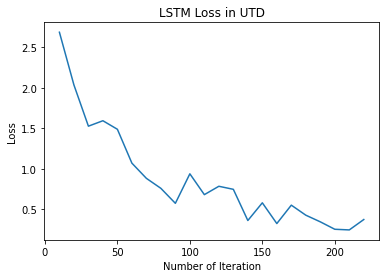

In [19]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM Loss in UTD")
plt.show()

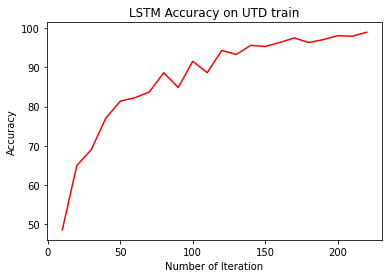

In [20]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy on UTD train")
plt.show()

Test Accuracy of the basic LSTM model on the UTD test features: 78.03468322753906 %


Text(241.44, 0.5, 'predicted label')

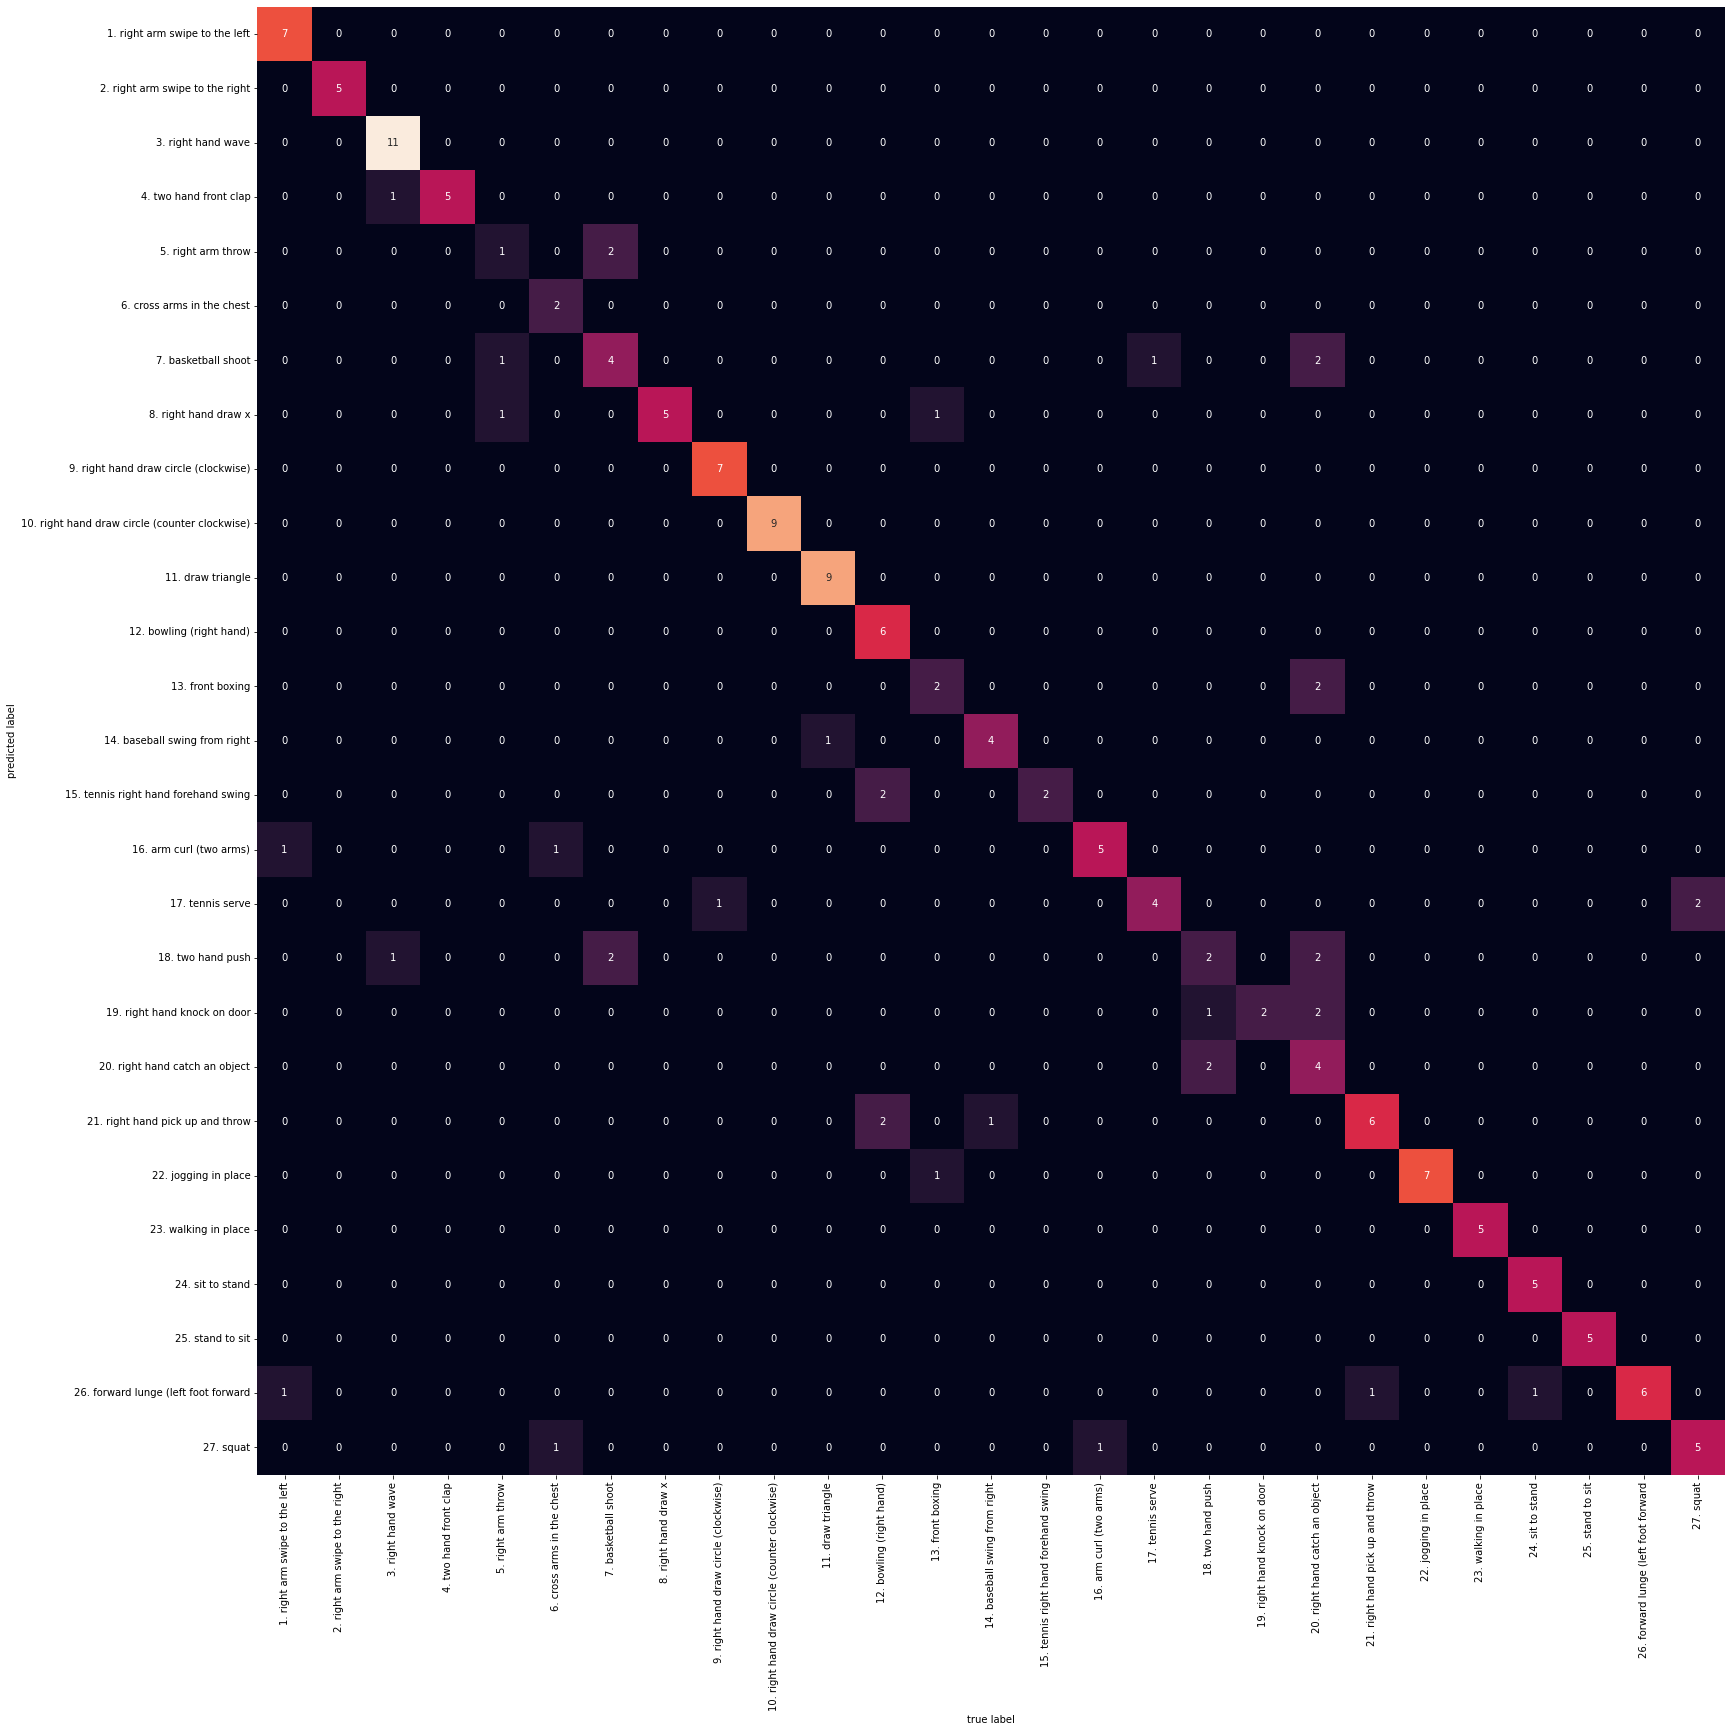

In [21]:
labels_list = []
predictions = []
classes = [
     '1. right arm swipe to the left', 
    '2. right arm swipe to the right', 
    '3. right hand wave',
    '4. two hand front clap',
    '5. right arm throw',
    '6. cross arms in the chest',
    '7. basketball shoot', 
    '8. right hand draw x',
    '9. right hand draw circle (clockwise)',
    '10. right hand draw circle (counter clockwise)',
    '11. draw triangle', 
    '12. bowling (right hand)', 
    '13. front boxing',
    '14. baseball swing from right',
    '15. tennis right hand forehand swing',
    '16. arm curl (two arms)', 
    '17. tennis serve', 
    '18. two hand push',
    '19. right hand knock on door', 
    '20. right hand catch an object',
    '21. right hand pick up and throw',
    '22. jogging in place',
    '23. walking in place',
    '24. sit to stand', 
    '25. stand to sit', 
    '26. forward lunge (left foot forward',
    '27. squat'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic LSTM model on the UTD test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(27, 27))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

### Try RNN

In [22]:
# rnn
# num_feature = 6
# feature_width = 128
class RNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #循环对象
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = "relu")
        
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())# detach 分离
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t
            
        return out
        
        
    

Here the hidden_dim has number = 100 will have a better performances

In [23]:
input_dim = 128 # input dimension
hidden_dim = 100 # hidden layers number 
layer_dim = 2
output_dim = 27 + 1 # output dimension

# initialize the model
model_rnn = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_rnn.parameters(), lr = learning_rate)

In [25]:
length = (len(list(model_rnn.parameters())))

In [26]:
for i in range(length):
    print("parameters: %d" %(i+1))
    print(list(model_rnn.parameters())[i].size())

parameters: 1
torch.Size([100, 128])
parameters: 2
torch.Size([100, 100])
parameters: 3
torch.Size([100])
parameters: 4
torch.Size([100])
parameters: 5
torch.Size([100, 100])
parameters: 6
torch.Size([100, 100])
parameters: 7
torch.Size([100])
parameters: 8
torch.Size([100])
parameters: 9
torch.Size([28, 100])
parameters: 10
torch.Size([28])


In [27]:
sequence_dim = 6
loss_list = []
accuracy_list = []
iteration_list = [] 
# 24576 = 32*1*6*128
iter =  0
for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_rnn.train()
        # A batch of data with transfering the RNN input dimention 
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        output = model_rnn(images)

        
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_rnn = criterion(output, labels)
        # backword
        loss_rnn.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 5 == 0:
            model_rnn.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_rnn(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            loss_list.append(loss_rnn.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_rnn.item(), accuracy))
            
            
          
                    
        

Iter:5,loss:6.90195369720459,Accuracy:8.866278648376465
Iter:10,loss:3.5460896492004395,Accuracy:17.587207794189453
Iter:15,loss:2.955219268798828,Accuracy:27.761629104614258
Iter:20,loss:2.587924003601074,Accuracy:28.92441749572754
Iter:25,loss:2.7588295936584473,Accuracy:32.848838806152344
Iter:30,loss:2.716780424118042,Accuracy:34.156978607177734
Iter:35,loss:2.0339858531951904,Accuracy:41.13372039794922
Iter:40,loss:2.1110286712646484,Accuracy:43.45930099487305
Iter:45,loss:1.4951659440994263,Accuracy:47.38372039794922
Iter:50,loss:2.07780122756958,Accuracy:51.453487396240234
Iter:55,loss:1.4068576097488403,Accuracy:50.29069900512695
Iter:60,loss:1.8722078800201416,Accuracy:47.23836898803711
Iter:65,loss:1.7278566360473633,Accuracy:57.41279220581055
Iter:70,loss:1.5589810609817505,Accuracy:59.30232238769531
Iter:75,loss:1.8228662014007568,Accuracy:62.5
Iter:80,loss:1.3656511306762695,Accuracy:63.66279220581055
Iter:85,loss:1.7062714099884033,Accuracy:63.226741790771484
Iter:90,loss

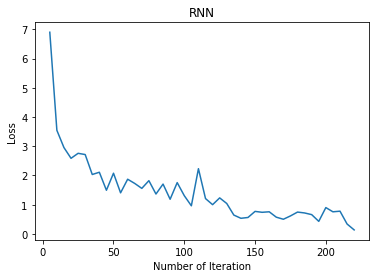

In [28]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("RNN")
plt.show()

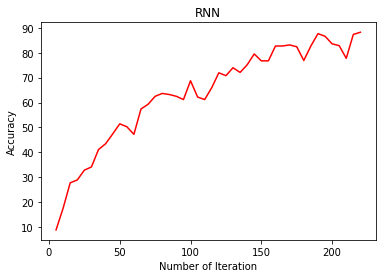

In [29]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("RNN")
plt.show()

Test Accuracy of the basic RNN model on the UTD test features: 60.69363784790039 %


Text(241.44, 0.5, 'predicted label')

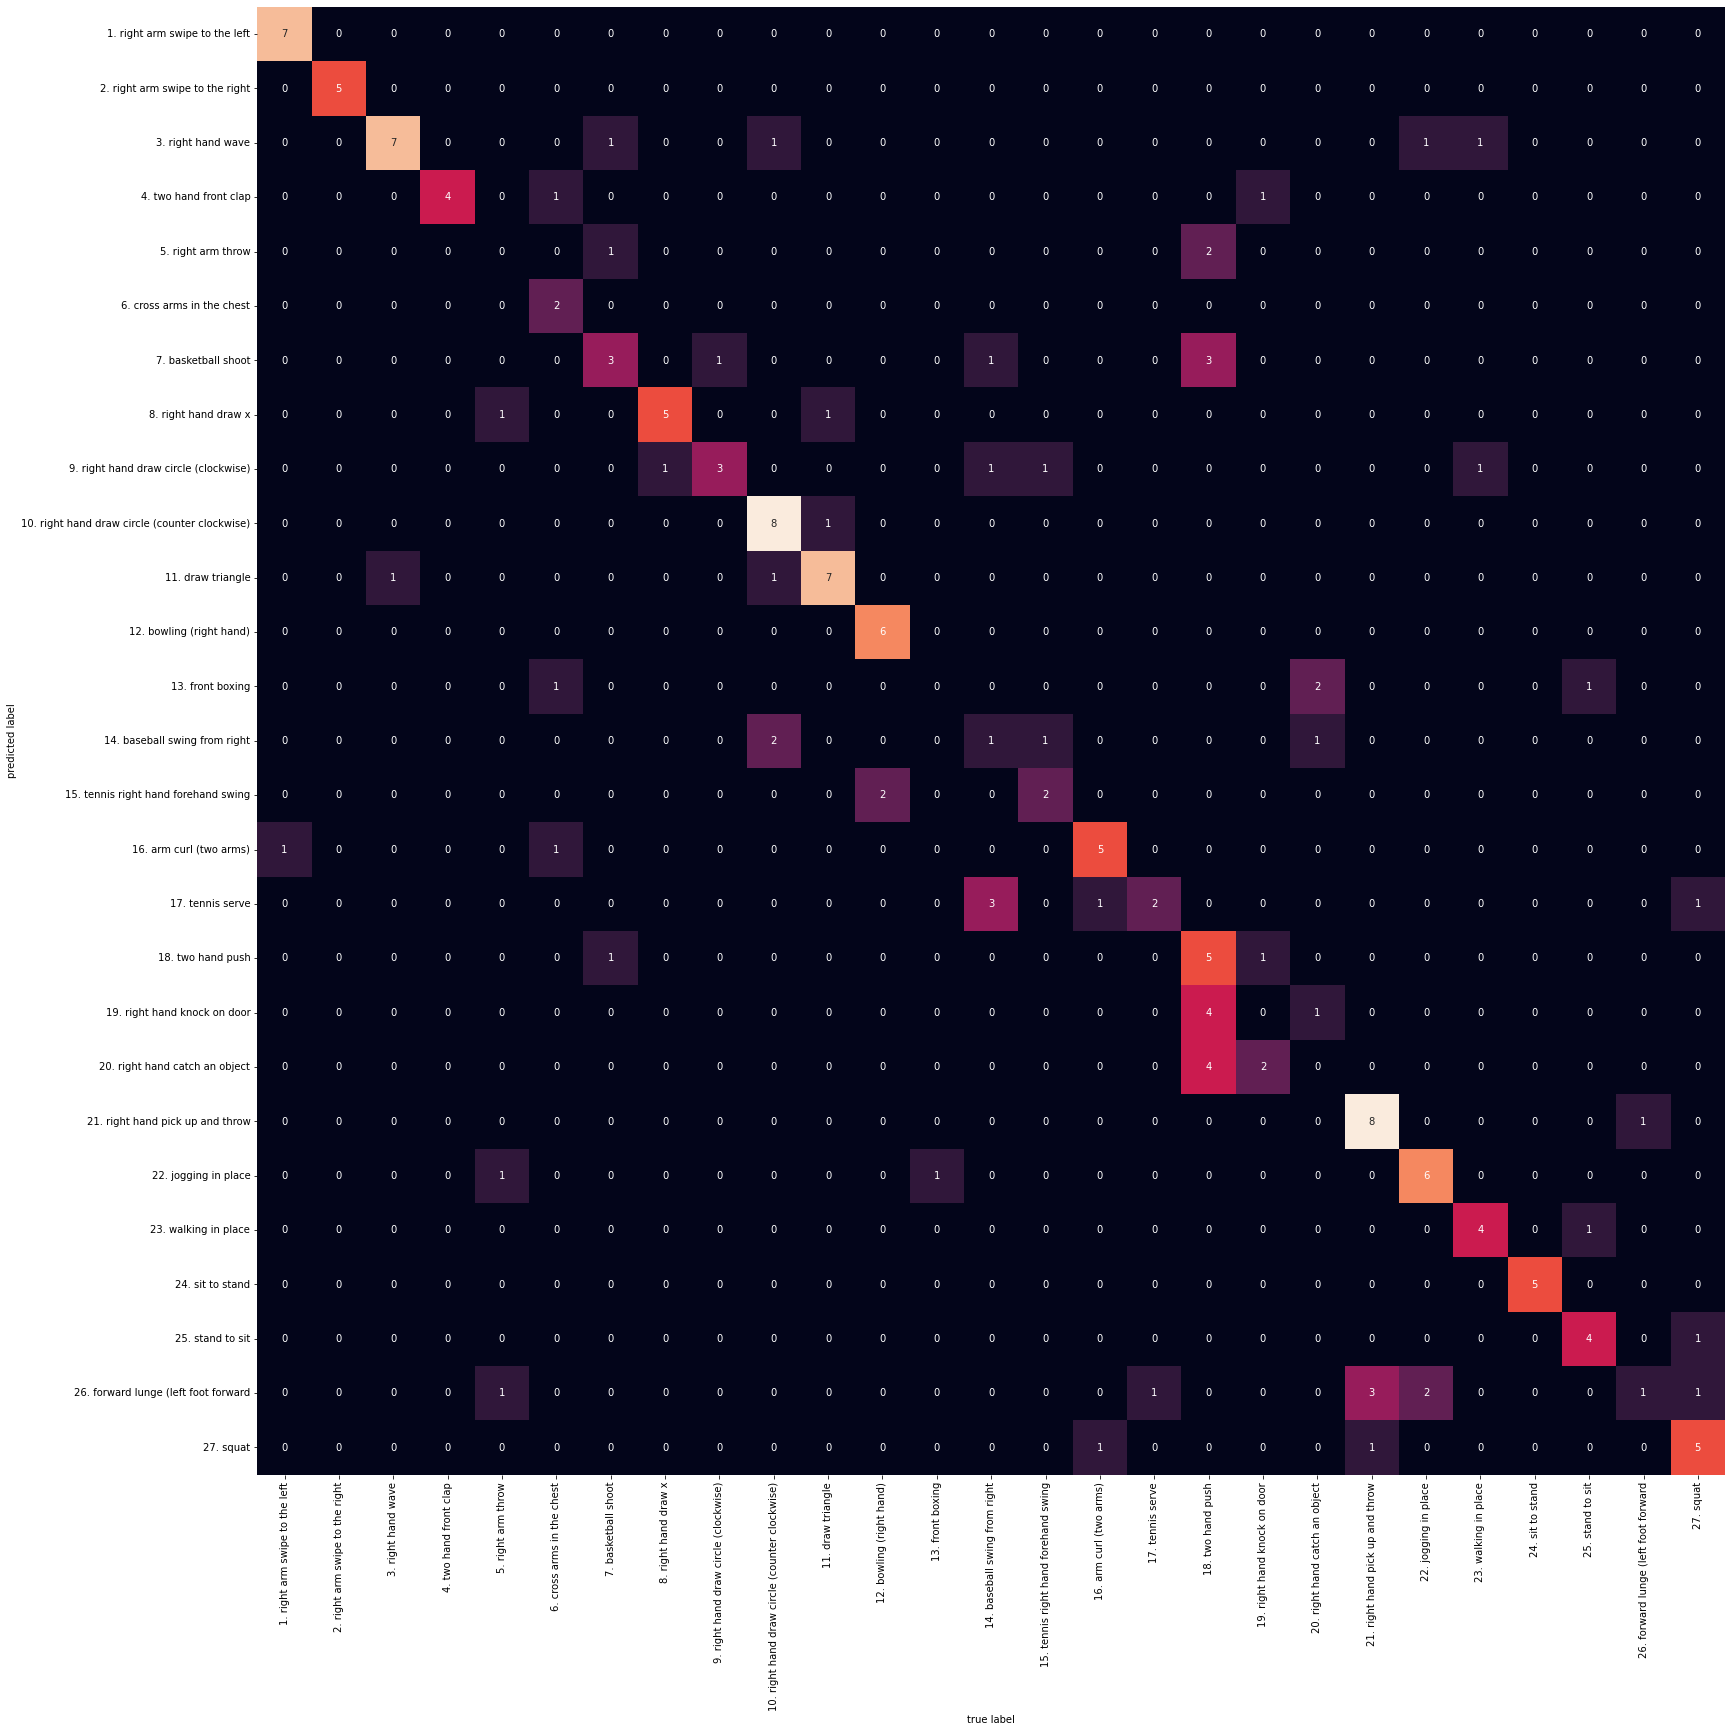

In [30]:
labels_list = []
predictions = []
classes = [
     '1. right arm swipe to the left', 
    '2. right arm swipe to the right', 
    '3. right hand wave',
    '4. two hand front clap',
    '5. right arm throw',
    '6. cross arms in the chest',
    '7. basketball shoot', 
    '8. right hand draw x',
    '9. right hand draw circle (clockwise)',
    '10. right hand draw circle (counter clockwise)',
    '11. draw triangle', 
    '12. bowling (right hand)', 
    '13. front boxing',
    '14. baseball swing from right',
    '15. tennis right hand forehand swing',
    '16. arm curl (two arms)', 
    '17. tennis serve', 
    '18. two hand push',
    '19. right hand knock on door', 
    '20. right hand catch an object',
    '21. right hand pick up and throw',
    '22. jogging in place',
    '23. walking in place',
    '24. sit to stand', 
    '25. stand to sit', 
    '26. forward lunge (left foot forward',
    '27. squat'
]

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_rnn(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
        predictions.append(predict)
        labels_list.append(labels)
    
    print('Test Accuracy of the basic RNN model on the UTD test features: {} %'.format((correct / total) * 100))
    
mat = metrics.confusion_matrix(torch.cat(predictions), torch.cat(labels_list))

plt.figure(figsize=(27, 27))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

#### Study the nature of activities and the number of classes
'1. right arm swipe to the left', 
    '2. right arm swipe to the right', 
    '3. right hand wave',
    '4. two hand front clap',
    '5. right arm throw',
    '6. cross arms in the chest',
    '7. basketball shoot', 
    '8. right hand draw x',
    '9. right hand draw circle (clockwise)',
    '10. right hand draw circle (counter clockwise)',
    '11. draw triangle', 
    '12. bowling (right hand)', 
    '13. front boxing',
    '14. baseball swing from right',
    '15. tennis right hand forehand swing',
    '16. arm curl (two arms)', 
    '17. tennis serve', 
    '18. two hand push',
    '19. right hand knock on door', 
    '20. right hand catch an object',
    '21. right hand pick up and throw',
    '22. jogging in place',
    '23. walking in place',
    '24. sit to stand', 
    '25. stand to sit', 
    '26. forward lunge (left foot forward',
    '27. squat


#### In RNN
Top 6: 10, 11, 12, 1, 9, 12

Top 12: 21, 27, 5, 16, 24

#### In LSTM

Top 6: 3, 10, 11, 9, 26, 21

Top 12: 21, 22, 16 , 7, 8, 23